In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os

import math


from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import datetime as dt

import warnings
warnings.filterwarnings('ignore')

2023-03-27 15:28:58.038581: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-27 15:28:58.101450: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-27 15:28:58.102477: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 15:28:58.998066: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

fname = 'data_normalized_change.csv'

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
lines.pop()

header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['', 'datetime', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol', 'ignore', 'ao', 'kama', 'ppo', 'pvo', 'roc', 'rsi', 'stochrsi', 'stoch', 'tsi', 'uo', 'wri', 'accdist', 'cmf', 'emv', 'fi', 'mfi', 'nvi', 'obv', 'smaemv', 'vpt', 'vwap', 'atr', 'ulcer', 'bbh', 'bbl', 'bbhi', 'bbli', 'bbmavg', 'bb_pb', 'bb_wb', 'dchb', 'dclb', 'dcmb', 'dcpb', 'dcwb', 'kchb', 'kclb', 'kchbi', 'kclbi', 'kcmb', 'kcpb', 'kcwb', 'adx', 'adx_neg', 'adx_pos', 'aroon_up', 'aroon_down', 'cci', 'dpo', 'kst', 'kst_sig', 'ema', 'ichimoku_a', 'ichimoku_b', 'ichimoku_base_line', 'ichimoku_conversion_line', 'macd', 'macd_diff', 'macd_signal', 'mi', 'sma', 'wma', 'stc', 'trix', 'psar_down_indicator', 'psar_up_indicator', 'vi_pos', 'vi_neg', 'ALU', 'WHEAT', 'XCU', 'BRENTOIL', 'COFFEE', 'SOYBEAN', 'NG', 'NI', 'RICE', 'XAU', 'IRD', 'SUGAR', 'ETHANOL', 'CORN', 'COTTON', 'TIN', 'ZNC', 'change_price']
525410


In [3]:
print(len(header))

99


In [5]:
change = np.zeros( (len(lines),1) )
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    #print(values)
    change[i] = values[97]
    raw_data[i, :] = values[:]
        


In [6]:
num_train_samples = int(0.5 * len(raw_data))  # Train
num_val_samples = int(0.25 * len(raw_data))   # Validation
num_test_samples = len(raw_data) - num_train_samples - num_val_samples  # Test
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 262705
num_val_samples: 131352
num_test_samples: 131353


In [7]:


# delay: time in future that will be predicted
# we want to predict 1 hours in the future
delay = 0


# sequence length: sequence lenght of each sample
# In this case we will take 360 samples historically for the sequence
sequence_length = 500


# sequence_stride: period between sequences
# First sequence starts at t0
# Second sequence will start at t1 with sequence_stride=1 or at t5 with sequence_stride=5
sequence_stride = 30


# sampling rate: period between timesteps within the sequence
# Sequence with rate=1 : t1,t2...tn
# Sequence with rate=3 : t1,t3...tn*3
sampling_rate = 5

#batch_size: Number of timeseries samples in each batch (except maybe the last one). 
#If None, the data will not be batched (the dataset will yield individual samples).
# Huge impact in performance.
# Tip, should be multiple of 8
batch_size = 64

# Understanding our parameters
msg = f"The timeseries will consist of batches containing {batch_size} sequences of {sequence_length} samples."

msg += f"\nFinally our target is {delay} timesteps in the future"
print(msg)

The timeseries will consist of batches containing 64 sequences of 500 samples.
Finally our target is 0 timesteps in the future


In [8]:
len(change)

525410

In [9]:

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data,
                    targets=change,
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=True, # Shouldn't the shuffle be set to 0?
                    seed=33,
                    batch_size=batch_size,
                    start_index=0,
                    end_index=num_train_samples)

print("Done Train")


val_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data,
                    targets=change,
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=True,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples,
                    end_index=num_train_samples + num_val_samples)

print("Done Validation")      
      
test_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data,
                    targets=change,
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=True,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples + num_val_samples)

print("Done Test")

Done Train
Done Validation
Done Test


In [10]:

for samples, targets in train_dataset:
    print("samples_shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
    
i =0
for samples, targets in train_dataset:
    i=i+1
    
print(i)

2023-03-27 15:32:50.572623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-03-27 15:32:50.573517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


samples_shape: (64, 500, 98)
targets shape: (64, 1)
136


In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(8, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("C:/models/first_model", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,epochs=15,validation_data=val_dataset,callbacks=callbacks)

model = keras.models.load_model("C:/models/first_model")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/15
131/136 [===========================>..] - ETA: 0s - loss: 70.4869 - mae: 1.3954

2023-03-27 15:32:54.081025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [131352,1]
	 [[{{node Placeholder/_20}}]]
2023-03-27 15:32:54.081924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [131352,98]
	 [[{{node Placeholder/_0}}]]


INFO:tensorflow:Assets written to: C:/models/first_model/assets


INFO:tensorflow:Assets written to: C:/models/first_model/assets


136/136 [==============================] - 3s 21ms/step - loss: 68.1388 - mae: 1.3656 - val_loss: 0.2579 - val_mae: 0.5062
Epoch 2/15
135/136 [============================>.] - ETA: 0s - loss: 0.1961 - mae: 0.4385

INFO:tensorflow:Assets written to: C:/models/first_model/assets


INFO:tensorflow:Assets written to: C:/models/first_model/assets


136/136 [==============================] - 2s 15ms/step - loss: 0.1958 - mae: 0.4382 - val_loss: 0.1408 - val_mae: 0.3730
Epoch 3/15
133/136 [============================>.] - ETA: 0s - loss: 0.0977 - mae: 0.3066

INFO:tensorflow:Assets written to: C:/models/first_model/assets


INFO:tensorflow:Assets written to: C:/models/first_model/assets


136/136 [==============================] - 2s 16ms/step - loss: 0.0971 - mae: 0.3055 - val_loss: 0.0597 - val_mae: 0.2409
Epoch 4/15
136/136 [==============================] - ETA: 0s - loss: 0.0342 - mae: 0.1752

INFO:tensorflow:Assets written to: C:/models/first_model/assets


INFO:tensorflow:Assets written to: C:/models/first_model/assets


136/136 [==============================] - 2s 18ms/step - loss: 0.0342 - mae: 0.1752 - val_loss: 0.0142 - val_mae: 0.1128
Epoch 5/15
131/136 [===========================>..] - ETA: 0s - loss: 0.0061 - mae: 0.0634

INFO:tensorflow:Assets written to: C:/models/first_model/assets


INFO:tensorflow:Assets written to: C:/models/first_model/assets


136/136 [==============================] - 2s 17ms/step - loss: 0.0060 - mae: 0.0623 - val_loss: 0.0017 - val_mae: 0.0262
Epoch 6/15
136/136 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0291

INFO:tensorflow:Assets written to: C:/models/first_model/assets


INFO:tensorflow:Assets written to: C:/models/first_model/assets


136/136 [==============================] - 2s 16ms/step - loss: 0.0024 - mae: 0.0291 - val_loss: 0.0017 - val_mae: 0.0247
Epoch 7/15
134/136 [============================>.] - ETA: 0s - loss: 0.0024 - mae: 0.0291

INFO:tensorflow:Assets written to: C:/models/first_model/assets


INFO:tensorflow:Assets written to: C:/models/first_model/assets


136/136 [==============================] - 2s 15ms/step - loss: 0.0024 - mae: 0.0291 - val_loss: 0.0017 - val_mae: 0.0245
Epoch 8/15
130/136 [===========================>..] - ETA: 0s - loss: 0.0024 - mae: 0.0290

INFO:tensorflow:Assets written to: C:/models/first_model/assets


INFO:tensorflow:Assets written to: C:/models/first_model/assets


136/136 [==============================] - 2s 18ms/step - loss: 0.0024 - mae: 0.0290 - val_loss: 0.0017 - val_mae: 0.0242
Epoch 9/15
136/136 [==============================] - 2s 15ms/step - loss: 0.0024 - mae: 0.0290 - val_loss: 0.0017 - val_mae: 0.0264
Epoch 10/15
136/136 [==============================] - 2s 12ms/step - loss: 0.0024 - mae: 0.0291 - val_loss: 0.0017 - val_mae: 0.0254
Epoch 11/15
136/136 [==============================] - 2s 15ms/step - loss: 0.0024 - mae: 0.0290 - val_loss: 0.0017 - val_mae: 0.0258
Epoch 12/15
136/136 [==============================] - 2s 12ms/step - loss: 0.0024 - mae: 0.0290 - val_loss: 0.0017 - val_mae: 0.0249
Epoch 13/15
136/136 [==============================] - 2s 13ms/step - loss: 0.0024 - mae: 0.0291 - val_loss: 0.0017 - val_mae: 0.0250
Epoch 14/15
136/136 [==============================] - 2s 13ms/step - loss: 0.0024 - mae: 0.0290 - val_loss: 0.0017 - val_mae: 0.0261
Epoch 15/15
134/136 [============================>.] - ETA: 0s - loss: 0.00

INFO:tensorflow:Assets written to: C:/models/first_model/assets


INFO:tensorflow:Assets written to: C:/models/first_model/assets


 1/68 [..............................] - ETA: 20s - loss: 0.0032 - mae: 0.0211

2023-03-27 15:33:27.009877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4296]
	 [[{{node Placeholder/_8}}]]
2023-03-27 15:33:27.010546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [131353,98]
	 [[{{node Placeholder/_0}}]]


68/68 [==============================] - 1s 7ms/step - loss: 9.5186e-04 - mae: 0.0121
Test MAE: 0.01


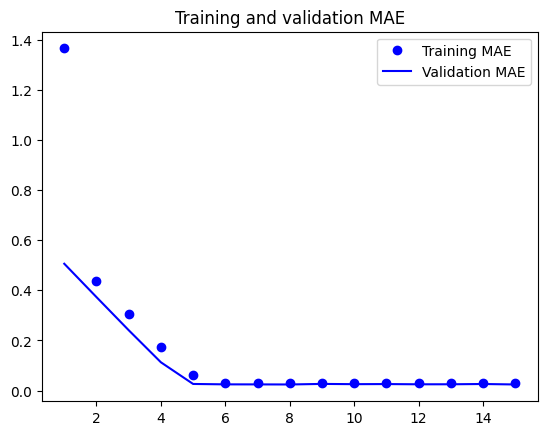

In [12]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

rnn

In [13]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("C:/models/lstm",
   save_best_only=True)
]


model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/30


2023-03-27 15:33:28.100051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 15:33:28.102180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 15:33:28.103587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

136/136 [==============================] - ETA: 0s - loss: 0.0055 - mae: 0.0501

2023-03-27 15:33:48.961675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 15:33:48.964033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 15:33:48.965839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


136/136 [==============================] - 28s 191ms/step - loss: 0.0055 - mae: 0.0501 - val_loss: 0.0037 - val_mae: 0.0498
Epoch 2/30
136/136 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0372

2023-03-27 15:34:18.849638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 15:34:18.851699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 15:34:18.853145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


136/136 [==============================] - 26s 192ms/step - loss: 0.0028 - mae: 0.0372 - val_loss: 0.0019 - val_mae: 0.0310
Epoch 3/30
136/136 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0359

2023-03-27 15:34:44.755736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 15:34:44.757735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 15:34:44.759185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


136/136 [==============================] - 26s 190ms/step - loss: 0.0027 - mae: 0.0359 - val_loss: 0.0019 - val_mae: 0.0301
Epoch 4/30
136/136 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0348

2023-03-27 15:35:09.393468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 15:35:09.395608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 15:35:09.397484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


136/136 [==============================] - 25s 181ms/step - loss: 0.0026 - mae: 0.0348 - val_loss: 0.0018 - val_mae: 0.0297
Epoch 5/30
136/136 [==============================] - 22s 159ms/step - loss: 0.0025 - mae: 0.0341 - val_loss: 0.0019 - val_mae: 0.0316
Epoch 6/30
136/136 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0338

2023-03-27 15:35:57.067115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 15:35:57.068875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 15:35:57.070303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


136/136 [==============================] - 26s 194ms/step - loss: 0.0025 - mae: 0.0338 - val_loss: 0.0018 - val_mae: 0.0289
Epoch 7/30
136/136 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0333

2023-03-27 15:36:23.136873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 15:36:23.138614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 15:36:23.140026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


136/136 [==============================] - 26s 189ms/step - loss: 0.0025 - mae: 0.0333 - val_loss: 0.0018 - val_mae: 0.0290
Epoch 8/30
136/136 [==============================] - 22s 161ms/step - loss: 0.0025 - mae: 0.0331 - val_loss: 0.0021 - val_mae: 0.0345
Epoch 9/30
136/136 [==============================] - 22s 159ms/step - loss: 0.0025 - mae: 0.0327 - val_loss: 0.0019 - val_mae: 0.0313
Epoch 10/30
136/136 [==============================] - 22s 159ms/step - loss: 0.0025 - mae: 0.0326 - val_loss: 0.0022 - val_mae: 0.0354
Epoch 11/30
136/136 [==============================] - 22s 159ms/step - loss: 0.0025 - mae: 0.0325 - val_loss: 0.0018 - val_mae: 0.0295
Epoch 12/30
136/136 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0323

2023-03-27 15:38:31.340056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 15:38:31.342155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 15:38:31.343620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


136/136 [==============================] - 26s 194ms/step - loss: 0.0025 - mae: 0.0323 - val_loss: 0.0018 - val_mae: 0.0282
Epoch 13/30
136/136 [==============================] - 22s 165ms/step - loss: 0.0024 - mae: 0.0322 - val_loss: 0.0019 - val_mae: 0.0315
Epoch 14/30
136/136 [==============================] - 22s 164ms/step - loss: 0.0024 - mae: 0.0322 - val_loss: 0.0019 - val_mae: 0.0315
Epoch 15/30
136/136 [==============================] - 22s 161ms/step - loss: 0.0024 - mae: 0.0320 - val_loss: 0.0024 - val_mae: 0.0377
Epoch 16/30
136/136 [==============================] - 22s 163ms/step - loss: 0.0024 - mae: 0.0321 - val_loss: 0.0020 - val_mae: 0.0328
Epoch 17/30
136/136 [==============================] - 22s 165ms/step - loss: 0.0024 - mae: 0.0319 - val_loss: 0.0019 - val_mae: 0.0316
Epoch 18/30
136/136 [==============================] - 22s 161ms/step - loss: 0.0024 - mae: 0.0318 - val_loss: 0.0018 - val_mae: 0.0286
Epoch 19/30
136/136 [==============================] - ETA: 

2023-03-27 15:42:07.390067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 15:42:07.391808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 15:42:07.393231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


136/136 [==============================] - 26s 191ms/step - loss: 0.0024 - mae: 0.0318 - val_loss: 0.0018 - val_mae: 0.0279
Epoch 20/30
136/136 [==============================] - 22s 163ms/step - loss: 0.0024 - mae: 0.0317 - val_loss: 0.0018 - val_mae: 0.0293
Epoch 21/30
136/136 [==============================] - 22s 164ms/step - loss: 0.0024 - mae: 0.0314 - val_loss: 0.0018 - val_mae: 0.0286
Epoch 22/30
136/136 [==============================] - 22s 160ms/step - loss: 0.0024 - mae: 0.0316 - val_loss: 0.0028 - val_mae: 0.0419
Epoch 23/30
136/136 [==============================] - 22s 164ms/step - loss: 0.0024 - mae: 0.0315 - val_loss: 0.0018 - val_mae: 0.0281
Epoch 24/30
136/136 [==============================] - 22s 163ms/step - loss: 0.0024 - mae: 0.0315 - val_loss: 0.0018 - val_mae: 0.0279
Epoch 25/30
136/136 [==============================] - 24s 175ms/step - loss: 0.0024 - mae: 0.0314 - val_loss: 0.0020 - val_mae: 0.0324
Epoch 26/30
136/136 [==============================] - 22s 1

In [14]:
model = keras.models.load_model("C:/models/lstm")

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

2023-03-27 15:47:09.469275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-03-27 15:47:09.469445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-03-27 15:47:09.469558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

68/68 [==============================] - 4s 48ms/step - loss: 0.0021 - mae: 0.0335
Test MAE: 0.03


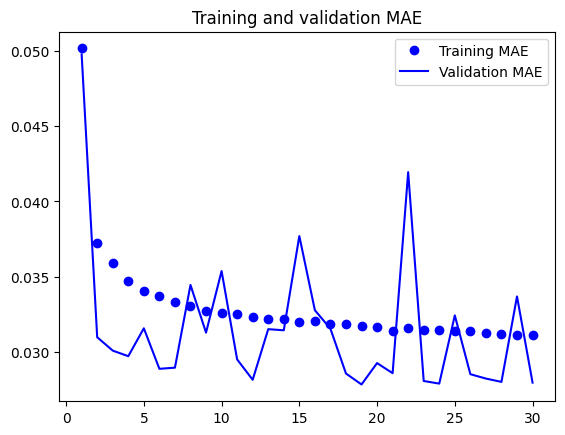

In [15]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

rnn 2

In [ ]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32)(inputs)
outputs = layers.Dropout(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("C:/models/lstm2",
   save_best_only=True)
]


model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
